In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob

import tensorflow as tf

from sklearn.cluster import KMeans
from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering

from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_decision_forests as tfdf

from sklearn.datasets import make_classification

print(tf.__version__)

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

2.8.0


### Club all the traces together into a single dataframe

In [3]:
path = './traces_core'# use your path
#all_files = glob.glob(path + "/*.h5")
all_files = glob.glob(path + "/dpotrf_T-200_C-20-*.prof*")

li = []

for filename in all_files:
    trace =  pd.HDFStore(filename)
    data = trace.get('/events')
    trace.close()
    
    li.append(data)
    print(filename)

df = pd.concat(li, axis=0, ignore_index=True)


./traces_core/dpotrf_T-200_C-20-1.prof.h5
./traces_core/dpotrf_T-200_C-20-0.prof.h5


In [4]:
print(len(li))

2


# Clean the data

In [5]:
df = df[['begin', 'end', 'taskpool_id', 'task_class_id','chore_id', 'nb_data_items', 'total_data_size', 'priority']].copy()
df['exec_time'] = (df['end'] - df['begin']) * .001 #0.001 nano seconds to micro seconds
df = df.astype(float)

In [6]:
df_class_name = {0: 'dpotrf', 1: 'dtrsm', 2: 'dsyrk', 3: 'dgemm'}

In [7]:

filter = ( (df['task_class_id'] >= 0 ) & ( df['task_class_id'] <= 3 ) & ( df['priority'] >= 0 ) )
#remove all other classes other than dpotrf, dgemm, trsm and syrk
df = df[filter]
df.head()

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,exec_time
0,467628.0,1655613.0,2.0,1.0,0.0,2.0,320000.0,0.0,1187.985
1,1670297.0,2906438.0,2.0,2.0,0.0,1.0,320000.0,0.0,1236.141
2,2929066.0,4048278.0,2.0,1.0,0.0,2.0,320000.0,0.0,1119.212
3,4060438.0,4334263.0,2.0,1.0,0.0,2.0,320000.0,0.0,273.825
4,4344065.0,5229696.0,2.0,1.0,0.0,2.0,320000.0,0.0,885.631


## integrate likelihood of the data being in cash.
we assume that all the task whose execution time is in the first quartile could have had all its data in the cache. While, the rest of the tasks would have resulted in a cache flush. While predicting we assume that the that the data of the task is not in the cache 

In [8]:
df[df['task_class_id'] == 3].head()

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,exec_time
127,9.327152e+08,9.357787e+08,4.0,3.0,0.0,3.0,960000.0,730680.0,3063.466
128,9.362568e+08,9.584290e+08,4.0,3.0,0.0,3.0,960000.0,779282.0,22172.171
129,9.584675e+08,9.893225e+08,4.0,3.0,0.0,3.0,960000.0,265149.0,30854.994
131,1.063461e+09,1.064098e+09,4.0,3.0,0.0,3.0,960000.0,483354.0,636.507
132,1.064120e+09,1.064701e+09,4.0,3.0,0.0,3.0,960000.0,616267.0,581.371


In [9]:
df.reset_index(inplace=True)

----------------- dpotrf [before] -------------------------- 
Min = 278.246
Max = 33326.695
Avg = 559.1858366666664
Std = 2631.8611680022427
----------------- dpotrf [after] -------------------------- 
Min = 278.246
Max = 350.338
Avg = 314.06553003533566
Std = 13.605070728987828
datapoints removed 5.666666666666666%
----------------- dtrsm [before] -------------------------- 
Min = 237.406
Max = 92696.582
Avg = 1208.6609220875448
Std = 4904.7012984669855
----------------- dtrsm [after] -------------------------- 
Min = 237.406
Max = 1034.358
Avg = 468.6352260231076
Std = 159.72206165245998
datapoints removed 3.2457912457912457%
----------------- dsyrk [before] -------------------------- 
Min = 180.67600000000002
Max = 95079.432
Avg = 1188.6743324092397
Std = 5044.2150736638805
----------------- dsyrk [after] -------------------------- 
Min = 346.72
Max = 595.264
Avg = 451.9809548620996
Std = 48.464465637846224
datapoints removed 7.141914191419143%
----------------- dgemm [before] -----

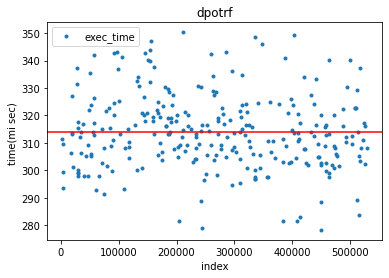

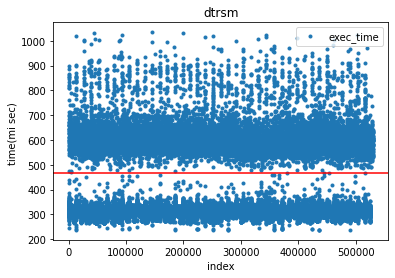

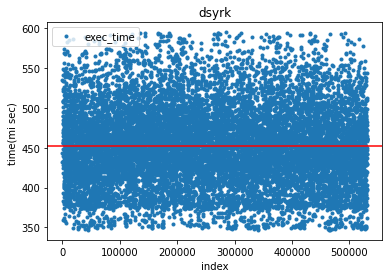

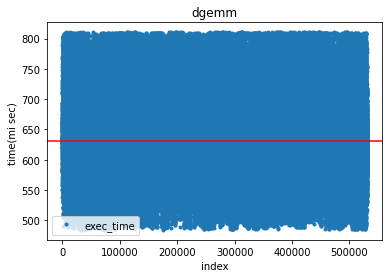

In [10]:
task_class_id = [0,1,2,3]

for i in task_class_id:
    
    df_exaxmple = df
    
    filter = (df_exaxmple['task_class_id'] == i )
    df_refined = df_exaxmple[filter]
    
    print('----------------- ' + df_class_name[i] + ' [before] -------------------------- ')
    print('Min = ' + str(df_refined['exec_time'].min()))
    print('Max = ' + str(df_refined['exec_time'].max()))
    print('Avg = ' + str(sum(df_refined['exec_time']) / len(df_refined['exec_time'])))
    print('Std = ' + str(df_refined['exec_time'].std()))
    datapoint1 = df_refined.shape[0]
    
    Q1 = df_refined['exec_time'].quantile(0.25)
    Q3 = df_refined['exec_time'].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.
    filter = (df_refined['exec_time'] >= Q1 - 1.5 * IQR) & (df_refined['exec_time'] <= Q3 + 1.5 *IQR)
    df_refined = df_refined.loc[filter]
    df_refined = df_refined.astype(float)
    
    print('----------------- ' + df_class_name[i] + ' [after] -------------------------- ')
    print('Min = ' + str(df_refined['exec_time'].min()))
    print('Max = ' + str(df_refined['exec_time'].max()))
    print('Avg = ' + str(sum(df_refined['exec_time']) / len(df_refined['exec_time'])))
    print('Std = ' + str(df_refined['exec_time'].std()))
    datapoint2 = df_refined.shape[0]
    
    perc_of_data = (datapoint1 - datapoint2) / datapoint1 * 100
    print('datapoints removed ' + str(perc_of_data) + '%')
    
    ax = df_refined.plot(y='exec_time',  use_index=True,
                    ylabel='time(mi sec) ', xlabel='index',
                    marker='.', linestyle='none',
                    title=df_class_name[i])
    ax.axhline(sum(df_refined['exec_time']) / len(df_refined['exec_time']), c='r')
    plt.savefig(df_class_name[i]+'_cloud', dpi=300)
    
    

## K-means

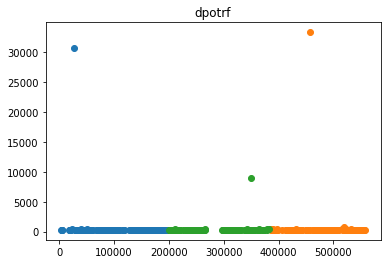

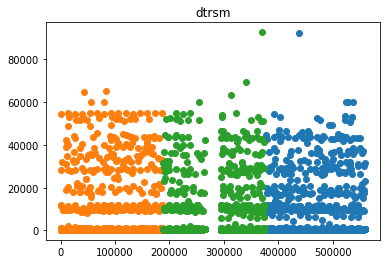

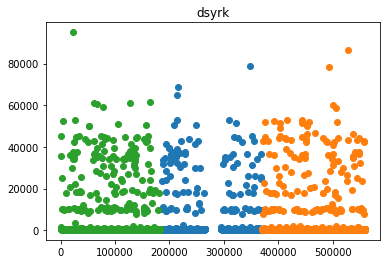

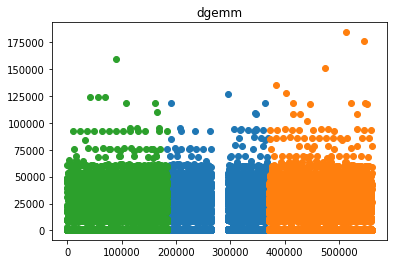

In [11]:
task_class_id = [0,1,2,3]

for i in task_class_id:
    # define dataset
    df_exaxmple = df
    filter = (df_exaxmple['task_class_id'] == i )
    df_refined = df_exaxmple[filter]
    x = df_refined[['index', 'exec_time']].copy()
    X = x.to_numpy()
    # define the model
    model = KMeans(n_clusters=3)
    # fit the model
    model.fit(X)
    # assign a cluster to each example
    yhat = model.predict(X)
    # retrieve unique clusters
    clusters = unique(yhat)
    # create scatter plot for samples from each cluster
    for cluster in clusters:
        # get row indexes for samples with this cluster
        row_ix = where(yhat == cluster)
        # create scatter of these samples
        pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
        pyplot.title(df_class_name[i])
    # show the plot
    pyplot.show()

## Reorder

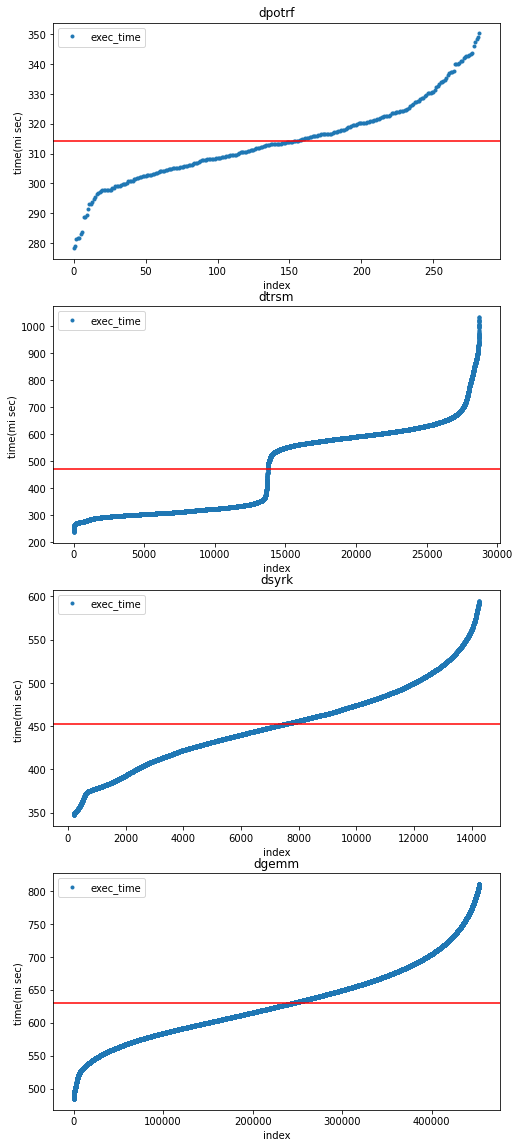

In [13]:
task_class_id = [0,1,2,3]
fig, axs = plt.subplots(4)
for i in task_class_id:
    
    df_exaxmple = df
    
    filter = (df_exaxmple['task_class_id'] == i )
    df_refined = df_exaxmple[filter]
    df_refined = df_refined.sort_values('exec_time', axis=0, ascending=True, 
                                        inplace=False, kind='quicksort', na_position='last')
    df_refined.insert(0, 'new_index', range(0, len(df_refined)))
    
    #print(df_refined.head())
    
    
    Q1 = df_refined['exec_time'].quantile(0.25)
    Q3 = df_refined['exec_time'].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.
    filter = (df_refined['exec_time'] >= Q1 - 1.5 * IQR) & (df_refined['exec_time'] <= Q3 + 1.5 *IQR)
    df_refined = df_refined.loc[filter]
    df_refined = df_refined.astype(float)
    
    
    
    ax = df_refined.plot(y='exec_time',  x='new_index',
                    ylabel='time(mi sec) ', xlabel='index',
                    marker='.', linestyle='none',
                    title=df_class_name[i], ax=axs[i], figsize=(8, 20))
    
    ax.axhline(sum(df_refined['exec_time']) / len(df_refined['exec_time']), c='r')
    #plt.savefig(df_class_name[i]+'_reorder', dpi=300)
plt.savefig('reorder_core_20', dpi=300)    
    
    




